Run 1 Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.9190, F1: 0.9190, SNR: 0.6196
Run 1 Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.8870, F1: 0.8867, SNR: 0.8940
Run 2 Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.9010, F1: 0.9010, SNR: 0.7874
Run 2 Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.9000, F1: 0.8999, SNR: 2.5634
Run 3 Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.9190, F1: 0.9190, SNR: 0.7715
Run 3 Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.8860, F1: 0.8860, SNR: 0.6694


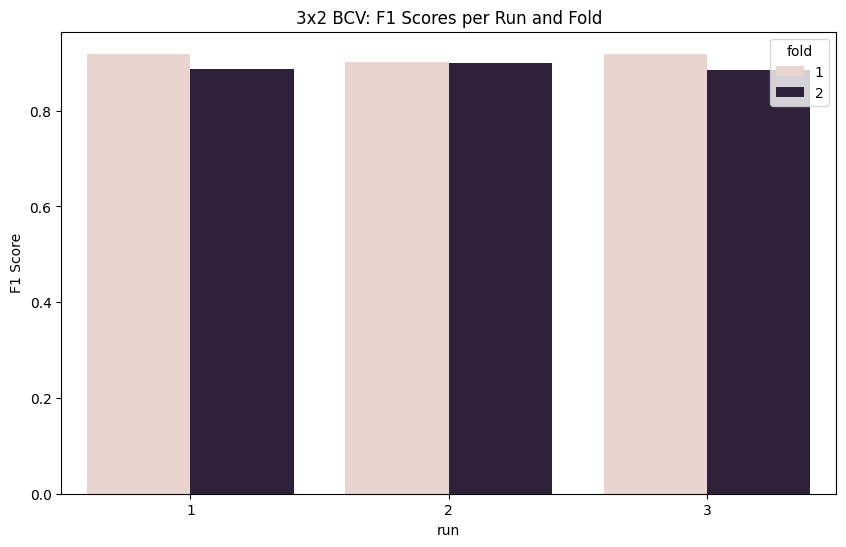

In [ ]:
# Install dependencies (for Colab or local with internet)
!pip install -q transformers datasets scikit-learn seaborn

import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from datasets import load_dataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

# Set random seeds
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Load Amazon dataset using HuggingFace datasets
def load_amazon_data(tokenizer, max_len=128, sample_size=2000):
    dataset = load_dataset("amazon_polarity")
    texts = dataset['train']['content'][:sample_size]
    labels = dataset['train']['label'][:sample_size]
    return TextClassificationDataset(texts, labels, tokenizer, max_len)

# Custom Dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer( # Tokenize the text dataset
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Signal-to-noise ratio calculation
def compute_snr_from_logits(logits, predicted_labels):
    """
    Computes SNR using model confidence (softmax score of predicted class) vs. uncertainty.
    """
    softmax_probs = torch.nn.functional.softmax(logits, dim=1)
    confidences = softmax_probs[range(len(predicted_labels)), predicted_labels]
    stds = torch.std(logits, dim=1)
    snr_scores = (confidences / (stds + 1e-8)).cpu().numpy()
    return np.mean(snr_scores)

class BlockedCrossValidator:
    def __init__(self, model_initializer, dataset, batch_size=8, epochs=2, learning_rate=2e-5):
        self.model_initializer = model_initializer
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def run(self):
        results = []
        for run in range(3):
            set_seed(42 + run)
            kf = KFold(n_splits=2, shuffle=True, random_state=42 + run)
            for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(self.dataset)))):
                print(f"Run {run+1} Fold {fold+1}")

# Create data loaders for training and testing
                train_loader = DataLoader(Subset(self.dataset, train_idx), batch_size=self.batch_size, shuffle=True)

# Create data loaders for training and testing
                val_loader = DataLoader(Subset(self.dataset, val_idx), batch_size=self.batch_size, shuffle=False)

                model = self.model_initializer().to(self.device)
                optimizer = AdamW(model.parameters(), lr=self.learning_rate)
                scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*self.epochs)
# Set model to training mode
                for epoch in range(self.epochs):
                    model.train()
                    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                        optimizer.zero_grad()
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels = batch['labels'].to(self.device)
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                        loss = outputs.loss
                        loss.backward() # Backpropagation step
                        optimizer.step() # Update model weights
                        scheduler.step()

                model.eval() # Set model to evaluation mode
                all_preds, all_labels, all_logits = [], [], []

                with torch.no_grad(): # Disable gradient computation during evaluation
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels = batch['labels'].to(self.device)
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                        logits = outputs.logits
                        preds = torch.argmax(logits, dim=1)

                        all_logits.append(logits.cpu())
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                all_logits_tensor = torch.cat(all_logits, dim=0)
                all_preds_tensor = torch.tensor(all_preds)

# Compute evaluation metrics
                acc = accuracy_score(all_labels, all_preds)

# Compute evaluation metrics
                f1 = f1_score(all_labels, all_preds, average='weighted')
                snr = compute_snr_from_logits(all_logits_tensor, all_preds_tensor)

                results.append({'run': run+1, 'fold': fold+1, 'accuracy': acc, 'f1': f1, 'snr': snr})
                print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, SNR: {snr:.4f}")

        self.plot_results(results)
        return results

    def plot_results(self, results):
        df = pd.DataFrame(results)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='run', y='f1', hue='fold')
        plt.title('3x2 BCV: F1 Scores per Run and Fold')
        plt.ylabel('F1 Score')
        plt.savefig("bert_amazon_f1.png")
        plt.show()

# Main function
def main():
    set_seed(42)

# Load pre-trained BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = load_amazon_data(tokenizer, sample_size=2000)  # use 2000 samples for demo
    
# Load pre-trained BERT model for classification
    def model_initializer():
        return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    bcv = BlockedCrossValidator(model_initializer, dataset)
    results = bcv.run()
    pd.DataFrame(results).to_csv("bert_amazon_results.csv", index=False)

if __name__ == '__main__':
    main()
